In [98]:
import util
import numpy as np
import os
import re
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import grid2op

In [99]:
config = util.load_config()

In [100]:
tutor_data_path = config['paths']['tutor_imitation']
#We have different folders each with records ran with different settings
data_folders = os.listdir(tutor_data_path)

re_data_folder_params_str = 'records_chronics_lout:(.*)_dnthreshold:(.*)'
re_cf_params_str = 'records_chronic:(.*).npy'
def get_params_from_dfolder_name(df):
    line_disabled, dn_threshold = re.search(re_data_folder_params_str, df).groups()
    return int(line_disabled), float(dn_threshold)
def get_chronic_id_from_file_name(df):
    return int(re.search(re_cf_params_str, df).groups(1)[0])
def generate_column_names_and_types(record_vect_size):
    standard_column_names = ['sel_action_idx','chronic_id','line_disabled','dn_threshold','forecasted_rho_dn'] + \
                            ['forecasted_rho_actn','search_dur_seconds','timestep'] 
    grid2op_vect_size = record_vect_size - len(standard_column_names)
    grid2op_vect_cnames = [f'grid2op_topo_vect_idx{idx}' for idx in range(grid2op_vect_size)]
    column_names = standard_column_names + grid2op_vect_cnames
    
    column_types = ['int32','int32','int32','float32','float32','float32','float32','int32'] + \
                    grid2op_vect_size * ['float64']
    return column_names,column_types,grid2op_vect_cnames
                
#def load_tutor_date
full_df = None
for df, (line_disabled, dn_threshold) in [(df,get_params_from_dfolder_name(df)) for df in data_folders]:
    chronic_records = os.listdir(os.path.join(tutor_data_path,df))
    dfolder_df = None
    
    for cf,cid in [(cf,get_chronic_id_from_file_name(cf)) for cf in chronic_records]:
        chronic_df = pd.DataFrame(np.load(os.path.join(tutor_data_path,df,cf)))
        chronic_df.insert(1,'cid',cid)
        chronic_df.insert(2,'line_disabled',line_disabled)
        chronic_df.insert(3,'dn_threshold',dn_threshold)
        
        if dfolder_df is None:
            dfolder_df = chronic_df
        else:
            dfolder_df = dfolder_df.append(chronic_df)

    if full_df is None:
        full_df = dfolder_df
    else:
        full_df = full_df.append(dfolder_df)
    
column_names, column_types, grid2op_vect_cnames = generate_column_names_and_types(len(full_df.columns))
full_df.columns =  column_names
full_df = full_df.astype(dict(zip(column_names, column_types)))

In [76]:
full_df

,sel_action_idx,chronic_id,line_disabled,dn_threshold,forecasted_rho_dn,forecasted_rho_actn,search_dur_seconds,timestep,grid2op_topo_vect_idx0,grid2op_topo_vect_idx1,...,grid2op_topo_vect_idx427,grid2op_topo_vect_idx428,grid2op_topo_vect_idx429,grid2op_topo_vect_idx430,grid2op_topo_vect_idx431,grid2op_topo_vect_idx432,grid2op_topo_vect_idx433,grid2op_topo_vect_idx434,grid2op_topo_vect_idx435,grid2op_topo_vect_idx436
0,96,35,-1,0.99,1.001929,0.873400,6.413164,804,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.789732,20.920769,1.0
1,96,35,-1,0.99,0.993028,0.870769,6.716555,958,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.904972,20.978672,1.0
2,97,35,-1,0.99,0.991127,0.894609,5.293333,1249,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.892221,20.972273,1.0
3,96,35,-1,0.99,0.998183,0.869978,5.371936,1533,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.866966,20.959591,1.0
4,96,35,-1,0.99,0.999347,0.872243,5.523936,2391,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.863596,20.957901,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,96,11,-1,0.97,0.980338,0.845750,5.591059,6562,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.758425,20.905010,1.0
21,96,11,-1,0.97,0.979047,0.851098,5.596108,6715,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.830412,20.941227,1.0
22,96,11,-1,0.97,0.982554,0.856664,5.613910,7000,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.873451,20.962849,1.0
23,52,11,-1,0.97,0.977292,0.908773,5.591695,7295,2019.0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-20.819885,20.935936,1.0


In [90]:
vect0 = np.array(full_df[grid2op_vect_cnames].iloc[0])
vect1 = np.array(full_df[grid2op_vect_cnames].iloc[1])

In [106]:
env = grid2op.make('rte_case14_realistic')
obs = env.reset()
#obs.from_vect(vect0)
ts0 = obs.get_time_stamp()

In [107]:
ts0

datetime.datetime(2019, 1, 6, 0, 0)

In [92]:
obs.from_vect(vect1)
ts1 = obs.get_time_stamp()

In [93]:
ts1 - ts0

datetime.timedelta(seconds=46200)

In [33]:
action_iders = {}

#set_topo_vect_columns = None
for row_idx,row in tqdm(full_df.iterrows(), total=full_df.shape[0]):
    
    line_disabled = row['line_disabled']
    sel_action_idx = int(row['sel_action_idx'])
    if line_disabled not in action_iders:
        action_iders[line_disabled] = util.action_identificator(line_disabled)
        
    set_topo_vect = action_iders[line_disabled].get_set_topo_vect(sel_action_idx)
    
    if row_idx == 0:
        set_topo_vect_columns = [f'set_topo_vect_idx{i}' for i in range(len(set_topo_vect))]
        full_df[set_topo_vect_columns] = 0

    for c,v in zip(set_topo_vect_columns,set_topo_vect):
        full_df.at[row_idx,c]=v

100%|██████████| 2385/2385 [00:52<00:00, 45.26it/s]


In [95]:
(full_df[set_topo_vect_columns]>1).mean()*100

KeyError: "None of [Index(['set_topo_vect_idx0', 'set_topo_vect_idx1', 'set_topo_vect_idx2',\n       'set_topo_vect_idx3', 'set_topo_vect_idx4', 'set_topo_vect_idx5',\n       'set_topo_vect_idx6', 'set_topo_vect_idx7', 'set_topo_vect_idx8',\n       'set_topo_vect_idx9', 'set_topo_vect_idx10', 'set_topo_vect_idx11',\n       'set_topo_vect_idx12', 'set_topo_vect_idx13', 'set_topo_vect_idx14',\n       'set_topo_vect_idx15', 'set_topo_vect_idx16', 'set_topo_vect_idx17',\n       'set_topo_vect_idx18', 'set_topo_vect_idx19', 'set_topo_vect_idx20',\n       'set_topo_vect_idx21', 'set_topo_vect_idx22', 'set_topo_vect_idx23',\n       'set_topo_vect_idx24', 'set_topo_vect_idx25', 'set_topo_vect_idx26',\n       'set_topo_vect_idx27', 'set_topo_vect_idx28', 'set_topo_vect_idx29',\n       'set_topo_vect_idx30', 'set_topo_vect_idx31', 'set_topo_vect_idx32',\n       'set_topo_vect_idx33', 'set_topo_vect_idx34', 'set_topo_vect_idx35',\n       'set_topo_vect_idx36', 'set_topo_vect_idx37', 'set_topo_vect_idx38',\n       'set_topo_vect_idx39', 'set_topo_vect_idx40', 'set_topo_vect_idx41',\n       'set_topo_vect_idx42', 'set_topo_vect_idx43', 'set_topo_vect_idx44',\n       'set_topo_vect_idx45', 'set_topo_vect_idx46', 'set_topo_vect_idx47',\n       'set_topo_vect_idx48', 'set_topo_vect_idx49', 'set_topo_vect_idx50',\n       'set_topo_vect_idx51', 'set_topo_vect_idx52', 'set_topo_vect_idx53',\n       'set_topo_vect_idx54', 'set_topo_vect_idx55'],\n      dtype='object')] are in the [columns]"

# Basic Inspections

In [101]:
df_dn_thr_097 = full_df[full_df['dn_threshold']==.97]
df_dn_thr_099 = full_df[full_df['dn_threshold']==.99]
df_dn_thr_100 = full_df[full_df['dn_threshold']==1.0]
dn_thresholds = [.97,.99,1.0]
dfs_different_thr = [df_dn_thr_097,df_dn_thr_099,df_dn_thr_100]

In [102]:
print("Lengths by dn_treshold:")
[print((thr,len(dfs_thr))) for thr,dfs_thr in zip(dn_thresholds,dfs_different_thr)]
pass

Lengths by dn_treshold:
(0.97, 1097)
(0.99, 714)
(1.0, 574)


In [131]:
770*20*20

308000

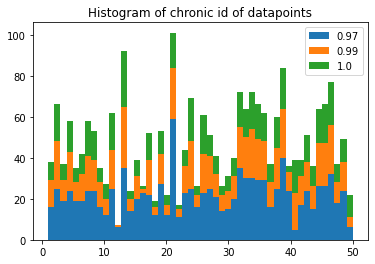

In [103]:
plt.hist([df['chronic_id'] for df in dfs_different_thr],stacked=True,bins=50,label=[.97,.99,1.0])
#plt.hist(df_dn_thr_099['chronic_id'],stacked=True,bins=50)
#plt.hist(df_dn_thr_100['chronic_id'],stacked=True,bins=50)
plt.title("Histogram of chronic id of datapoints")
plt.legend()

In [129]:
full_df['grid2op_topo_vect_idx2'][(full_df['dn_threshold']==1.0) & (full_df['chronic_id']==1)]

0     7.0
1     9.0
2    11.0
3    23.0
4    24.0
5    29.0
6    30.0
7    31.0
8     1.0
Name: grid2op_topo_vect_idx2, dtype: float64

In [130]:
full_df['grid2op_topo_vect_idx2'][(full_df['dn_threshold']==.97) & (full_df['chronic_id']==1)]

0      7.0
1      8.0
2      9.0
3     10.0
4     11.0
5     15.0
6     16.0
7     17.0
8     21.0
9     23.0
10    24.0
11    28.0
12    29.0
13    30.0
14    31.0
15     1.0
Name: grid2op_topo_vect_idx2, dtype: float64

In [116]:
(full_df['dn_threshold']==.99) + (full_df['chronic_id']==1)

0      True
1      True
2      True
3      True
4      True
      ...  
20    False
21    False
22    False
23    False
24    False
Length: 2385, dtype: bool

In [43]:
[df['chronic_id'] for df in dfs_different_thr]

[0     35
 1     35
 2     35
 3     35
 4     35
       ..
 20    11
 21    11
 22    11
 23    11
 24    11
 Name: chronic_id, Length: 1097, dtype: int64,
 0     35
 1     35
 2     35
 3     35
 4     35
       ..
 14    11
 15    11
 16    11
 17    11
 18    11
 Name: chronic_id, Length: 714, dtype: int64,
 0     35
 1     35
 2     35
 3     35
 4     35
       ..
 13    11
 14    11
 15    11
 16    11
 17    11
 Name: chronic_id, Length: 552, dtype: int64]

(array([6.100e+01, 4.700e+01, 4.400e+01, 5.200e+01, 3.900e+01, 3.370e+02,
        1.190e+02, 0.000e+00, 1.000e+00, 1.663e+03]),
 array([-1. ,  8.8, 18.6, 28.4, 38.2, 48. , 57.8, 67.6, 77.4, 87.2, 97. ]),
 <BarContainer object of 10 artists>)

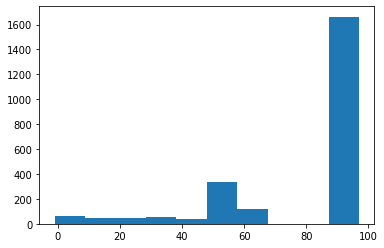

In [9]:
plt.hist(list(full_df['sel_action_idx']))

In [ ]:
plt.plot(full_df['chronic_id'])